In [1]:
import numpy as np
import pandas as pd
import warnings
import shap
import matplotlib.pyplot as plt

In [3]:
from geoshapley import GeoShapleyExplainer

In [4]:
size=25
def plot_s(bs,vmin=None,vmax=None, title = ""):
    k = len(bs)
    fig, axs = plt.subplots(1, k,figsize=(6*k,4),dpi=300)
    for i in range(k):
        ax = axs[i].imshow(bs[i].reshape(size,size),cmap=plt.cm.get_cmap('viridis',36),
                               vmin=vmin,vmax=vmax)
        
        fig.colorbar(ax, ax=axs[i])

        axs[i].set_xticks(np.arange(-0.5, size, 5))
        axs[i].set_yticks(np.arange(-0.5, size, 5))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])
        axs[i].tick_params(axis='x', colors=(0,0,0,0))
        axs[i].tick_params(axis='y', colors=(0,0,0,0))
        
    fig.suptitle(title, fontsize=20,y=1.05)

In [5]:
mgwr_sim = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/geoshapley/refs/heads/main/data/mgwr_sim.csv")

In [6]:
X_coords = mgwr_sim[['X1','X2','x_coord','y_coord']]
y = mgwr_sim.y.values

true = mgwr_sim[["b0","b1","b2"]].values

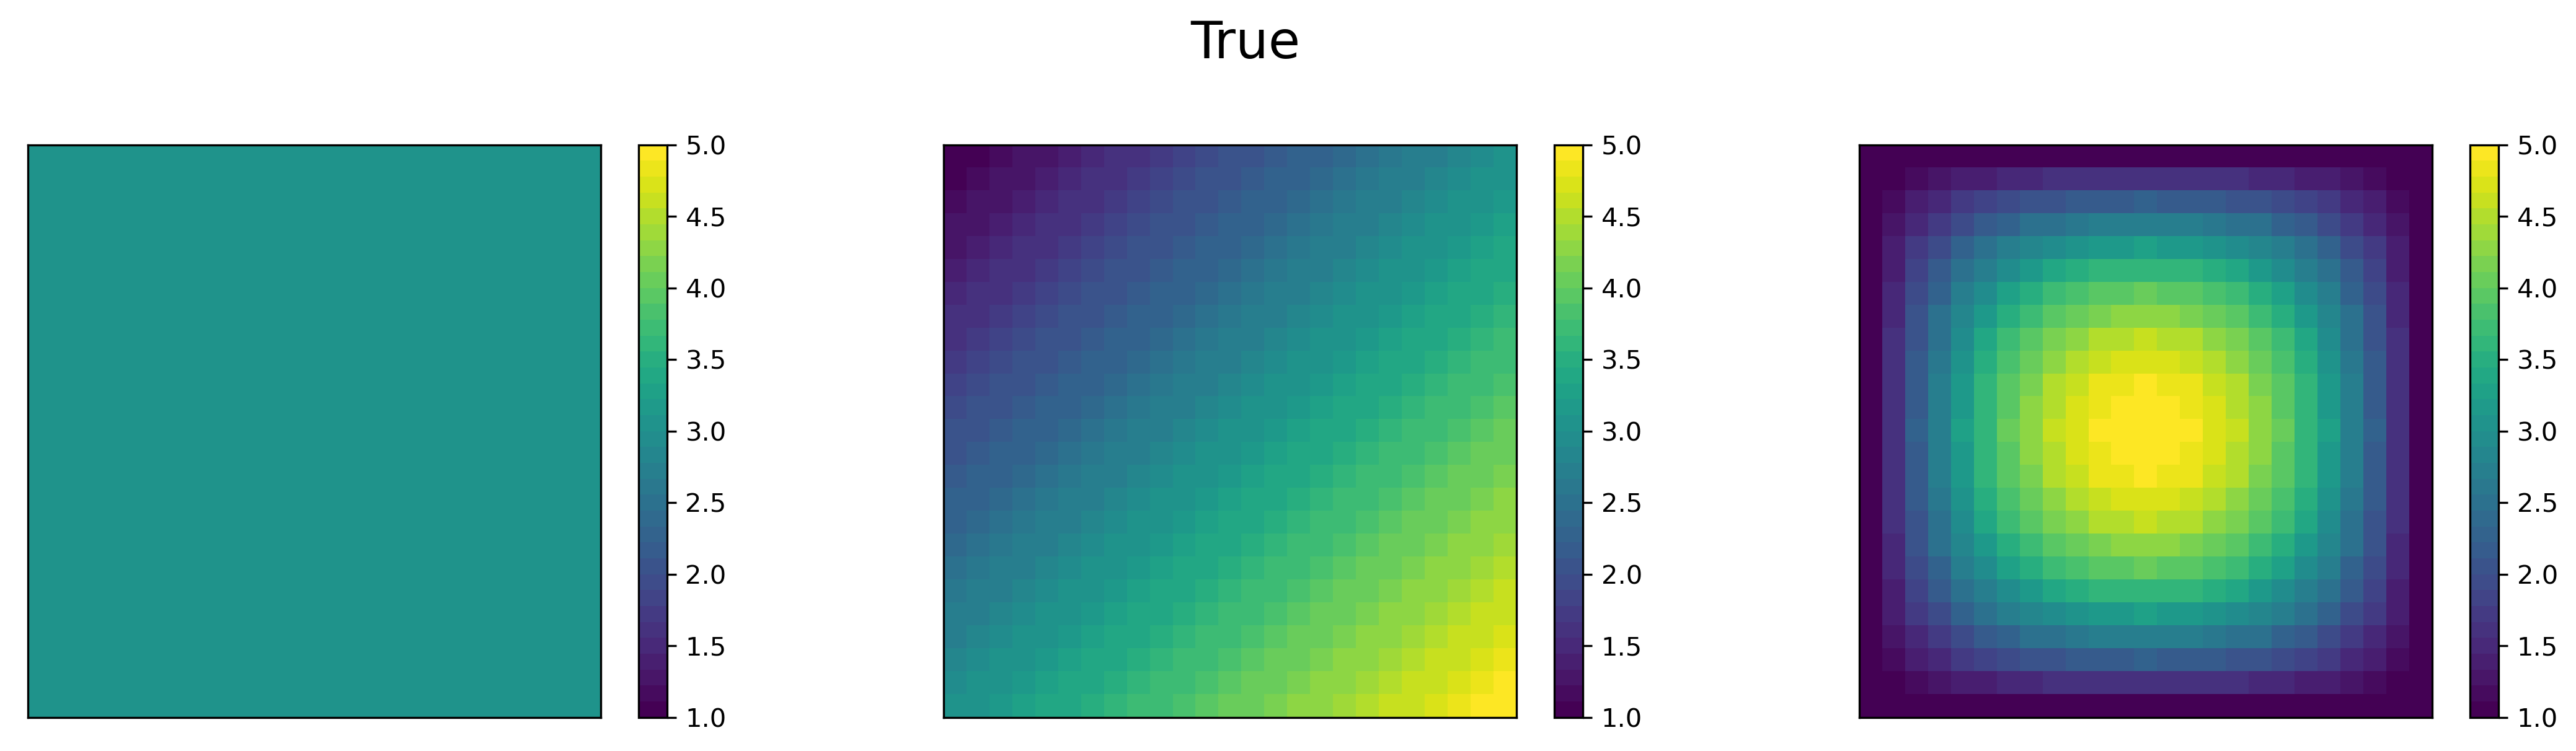

In [7]:
warnings.filterwarnings('ignore')
plot_s(true.T,vmin=1,vmax=5,title = "True")

## Fit ML

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_coords, y,random_state=1)

In [9]:
from hpsklearn import HyperoptEstimator, xgboost_regression, mlp_regressor
from hyperopt import tpe

In [10]:
def train_any_model(any_regressor,max_evals=10):
    estim = HyperoptEstimator(regressor=any_regressor("myModel"),preprocessing=[],
                              algo=tpe.suggest,max_evals=max_evals,trial_timeout=60,seed=1)
    estim.fit(X_train, y_train)
    return estim

In [11]:
%%time
for i in range(0,200):
    try:
        mlp_model = train_any_model(mlp_regressor)
        break
    except:
        pass

 67%|████████████████████████▋            | 2/3 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (251) reached and the optimization hasn't converged yet.
  warnings.warn(


 75%|███████████████████████████▊         | 3/4 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (182) reached and the optimization hasn't converged yet.
  warnings.warn(


 88%|████████████████████████████████▍    | 7/8 [00:00<?, ?trial/s, best loss=?]

/Users/ziqili/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


100%|███████| 10/10 [00:01<00:00,  1.90s/trial, best loss: 0.014177371867286959]
CPU times: user 5.94 s, sys: 2.45 s, total: 8.39 s
Wall time: 26.8 s


In [12]:
%%time
xgb_model = train_any_model(xgboost_regression)

100%|████████| 10/10 [00:01<00:00,  1.75s/trial, best loss: 0.03028529198833607]
CPU times: user 1.27 s, sys: 1.33 s, total: 2.6 s
Wall time: 18.9 s


## Explain ML

In [13]:
background_X = X_coords.values

### MLP

In [14]:
mlp_explainer = GeoShapleyExplainer(mlp_model.predict, background_X)

mlp_rslt = mlp_explainer.explain(X_coords,n_jobs=-1)

  0%|          | 0/625 [00:00<?, ?it/s]

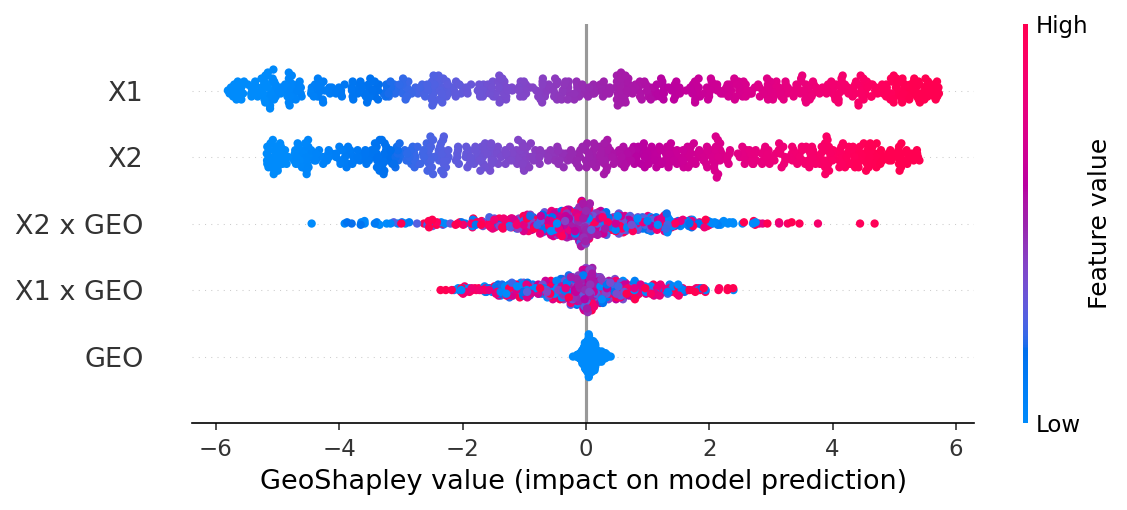

In [15]:
mlp_rslt.summary_plot(dpi=150)

In [16]:
mlp_rslt.summary_statistics()

,min,25%,50%,75%,max,mean,std,abs. mean
X1,-5.806290,-2.924641,0.053345,3.060743,5.723157,0.044004,3.451139,2.995747
X2,-5.175463,-2.627152,0.101265,2.714301,5.407084,0.029272,3.093979,2.678599
X2 x GEO,-4.448049,-0.715874,-0.049394,0.698419,4.680488,-0.058544,1.284700,0.948396
X1 x GEO,-2.357861,-0.631968,-0.038428,0.447572,2.391648,-0.088008,0.890159,0.686414
GEO,-0.209966,0.005486,0.059861,0.130269,0.400681,0.073276,0.098803,0.094483


### XGBoost

In [17]:
xgb_explainer = GeoShapleyExplainer(xgb_model.predict, background_X)

xgb_rslt = xgb_explainer.explain(X_coords, n_jobs=-1)

  0%|          | 0/625 [00:00<?, ?it/s]

In [18]:
xgb_rslt.summary_statistics

<bound method GeoShapleyResults.summary_statistics of <geoshapley.geoshapley.GeoShapleyResults object at 0x2d79a8650>>

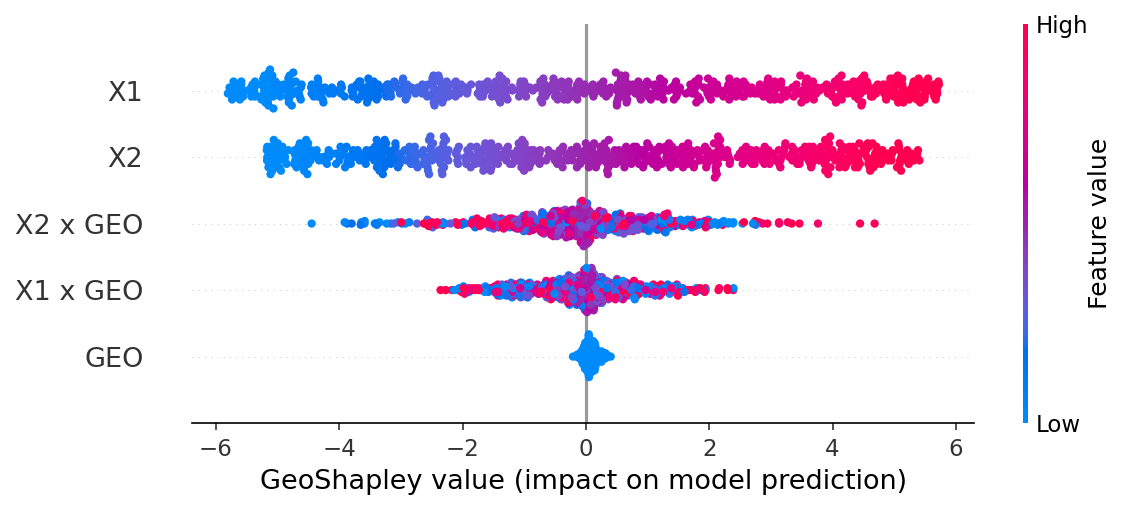

In [19]:
mlp_rslt.summary_plot(dpi=150)

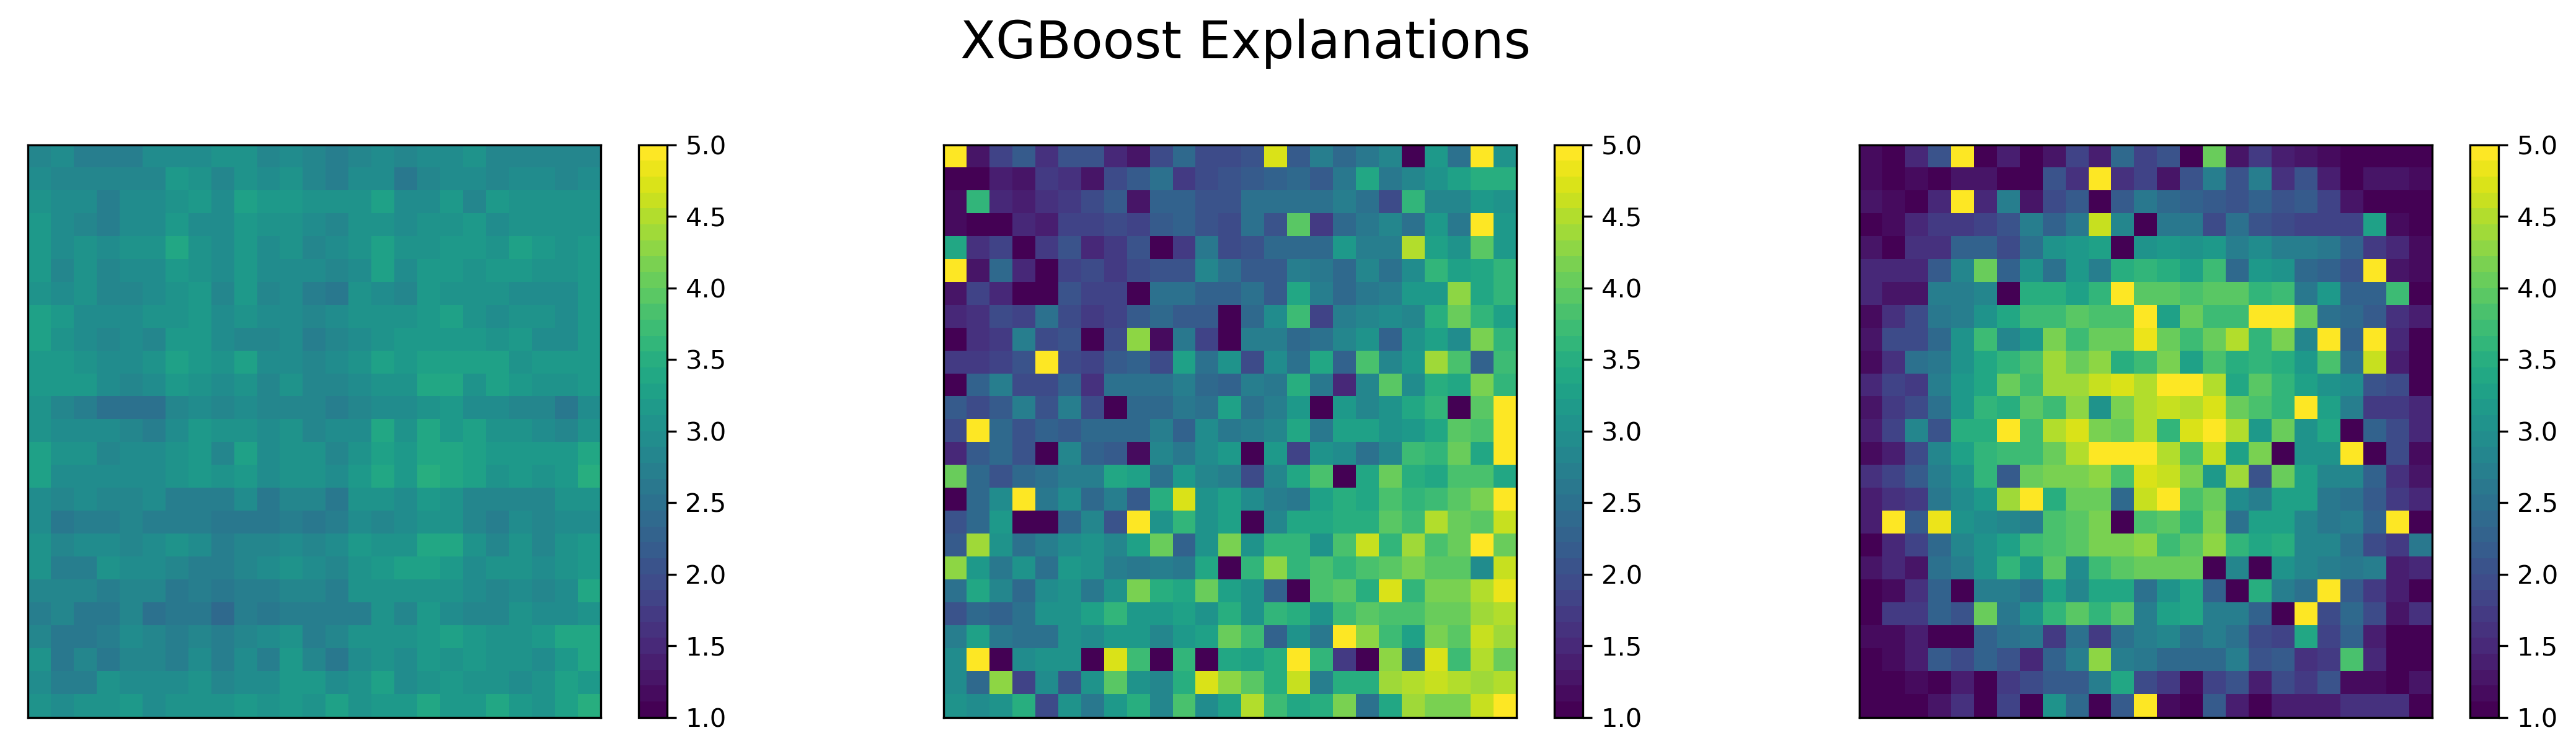

In [20]:
xgb_svc = xgb_rslt.get_svc(col = [0, 1],coef_type="raw",include_primary=True)

plot_s(np.hstack([xgb_rslt.base_value + xgb_rslt.geo.reshape(-1,1), xgb_svc]).T,
       vmin=1,vmax=5,title="XGBoost Explanations")

In [21]:
mlp_svc = mlp_rslt.get_svc(col = [0, 1],coef_type="raw",include_primary=True)

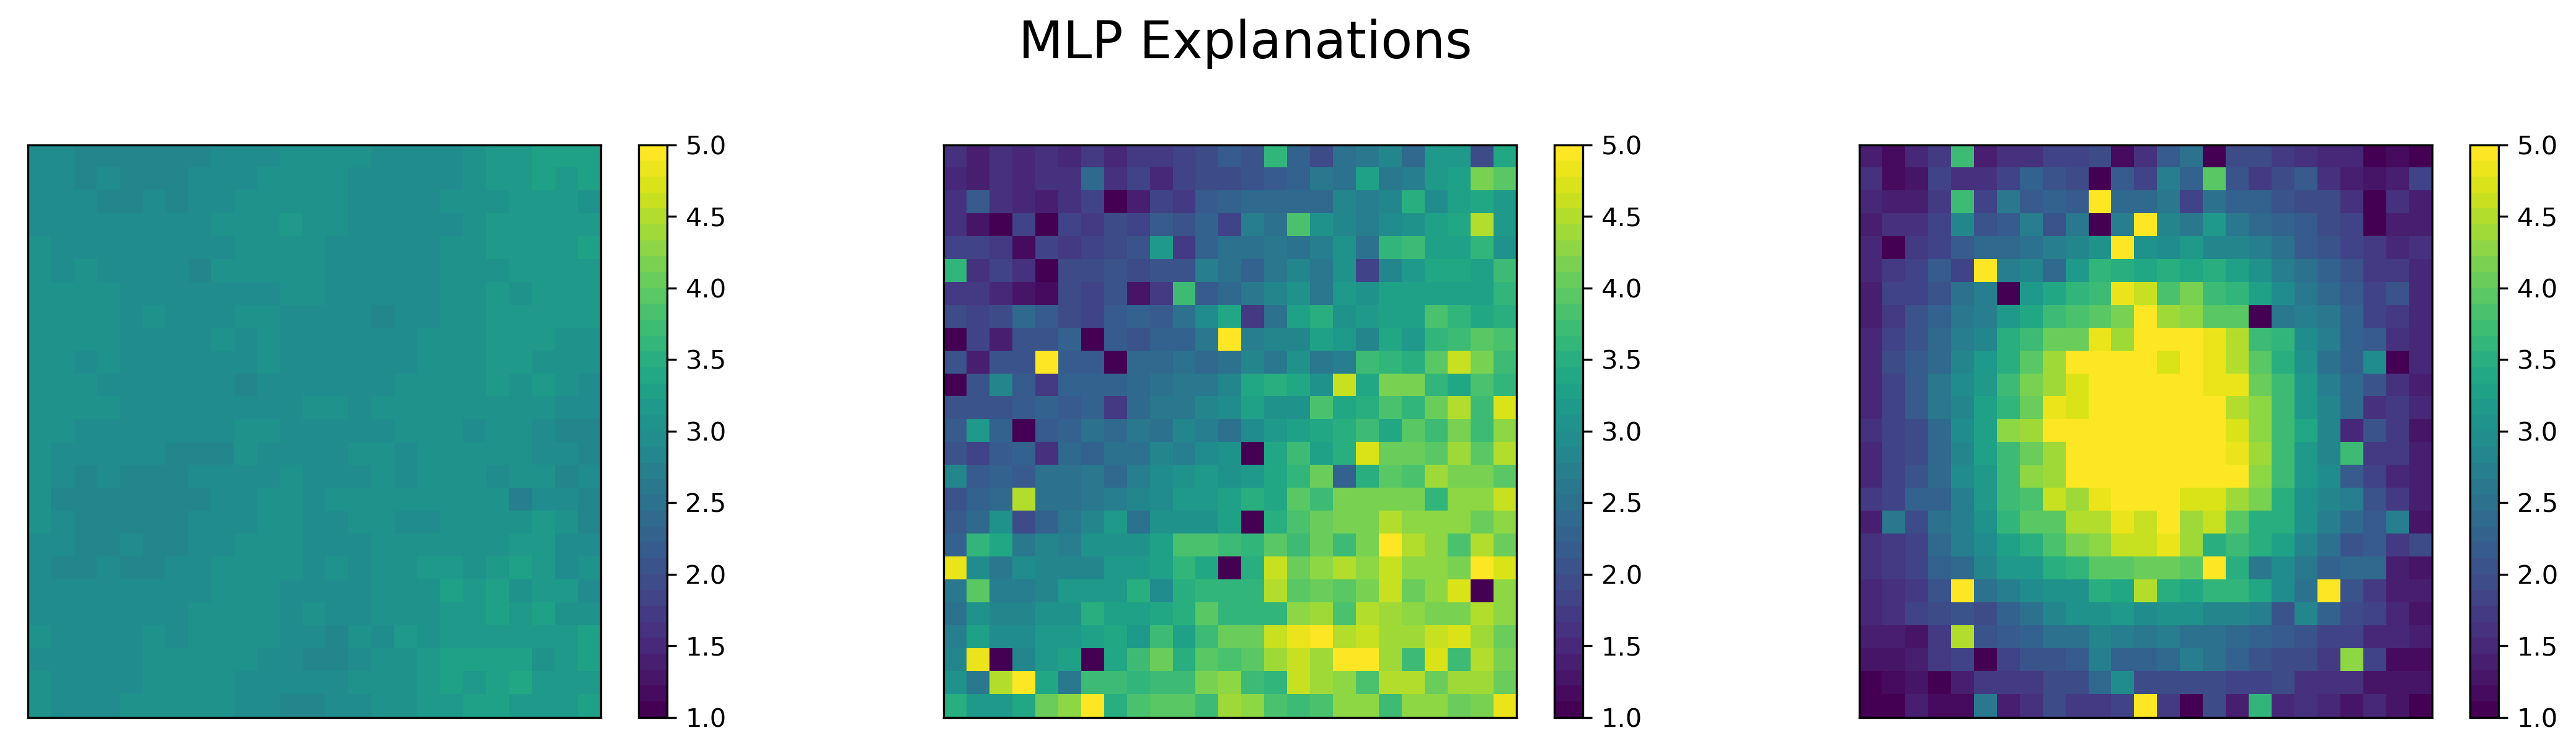

In [22]:
plot_s(np.hstack([mlp_rslt.base_value + mlp_rslt.geo.reshape(-1,1), mlp_svc]).T,
       vmin=1,vmax=5,title="MLP Explanations")

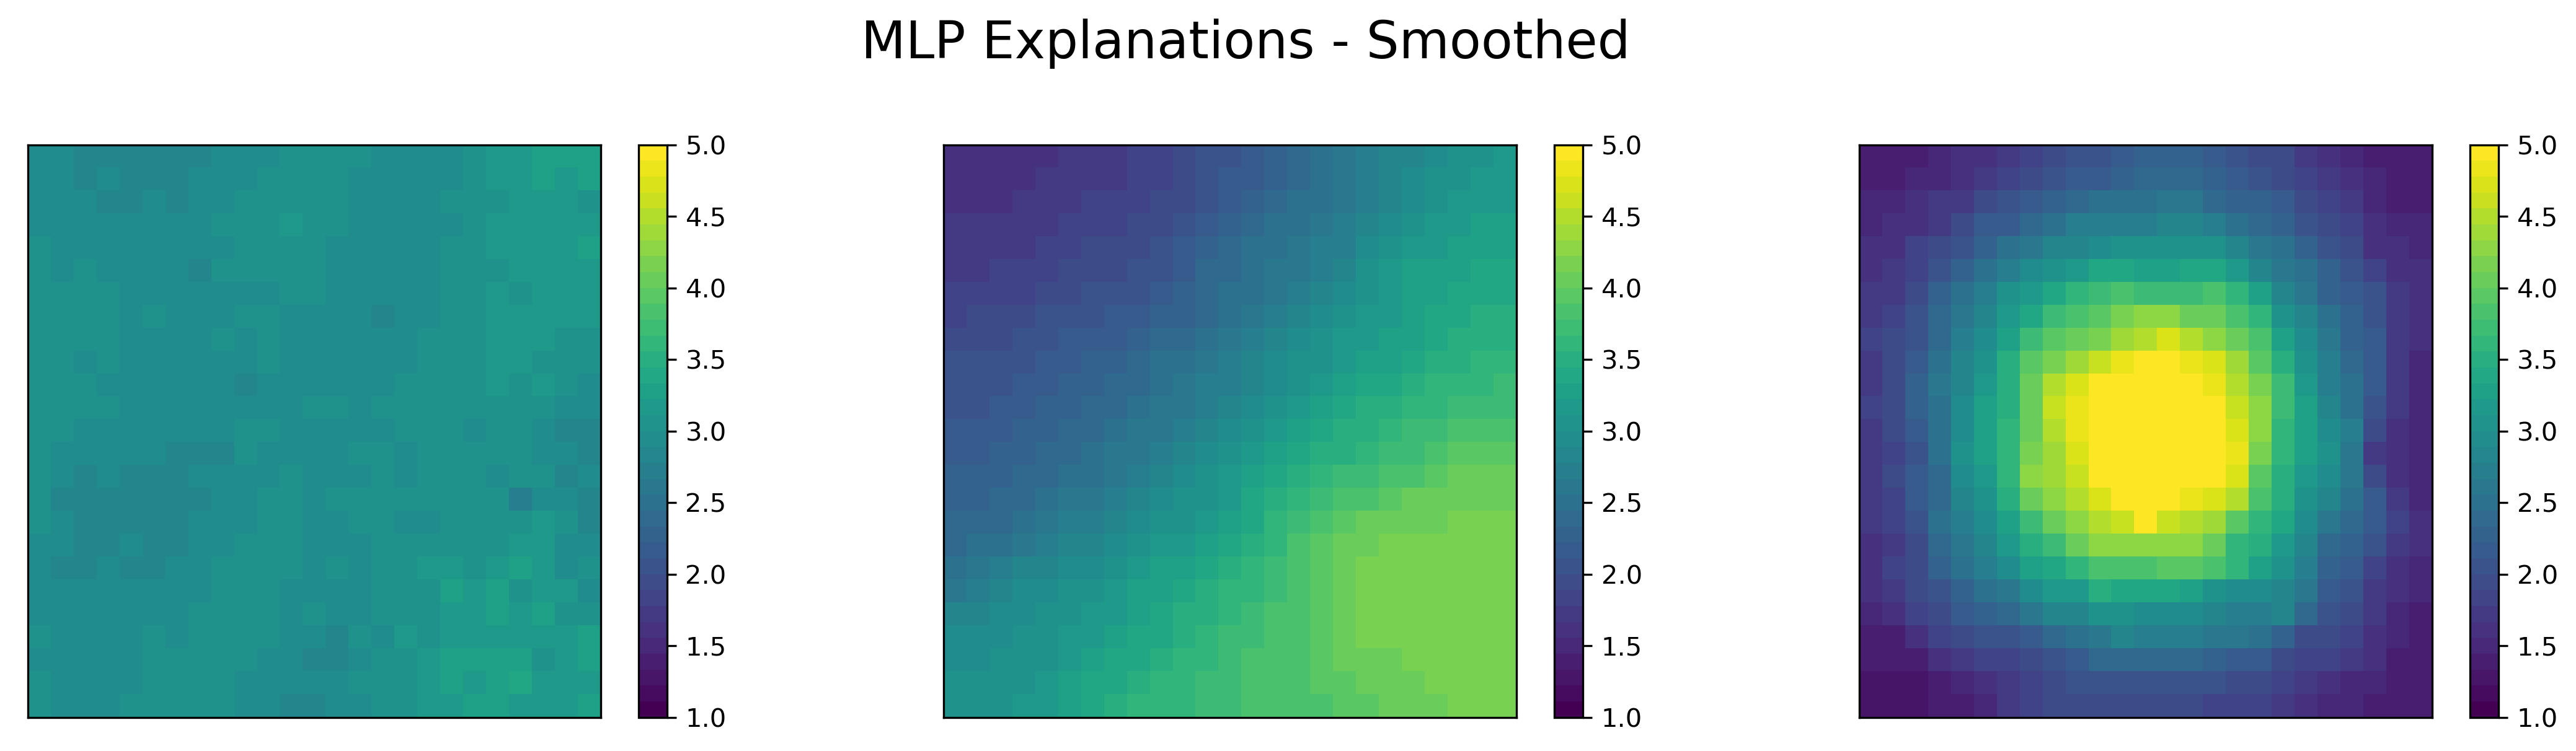

In [27]:
mlp_svc = mlp_rslt.get_svc(col = [0, 1],coef_type="gwr",include_primary=True)

plot_s(np.hstack([mlp_rslt.base_value + mlp_rslt.geo.reshape(-1,1), mlp_svc]).T,
       vmin=1,vmax=5,title="MLP Explanations - Smoothed")

## MGWR

In [24]:
from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

In [25]:
sel = Sel_BW(X_coords.values[:,-2:],y.reshape(-1,1),X_coords.values[:,:-2],multi=True)
sel.search()

mgwr_rslt = MGWR(X_coords.values[:,-2:],y.reshape(-1,1),X_coords.values[:,:-2],selector=sel).fit()

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

Inference:   0%|          | 0/1 [00:00<?, ?it/s]

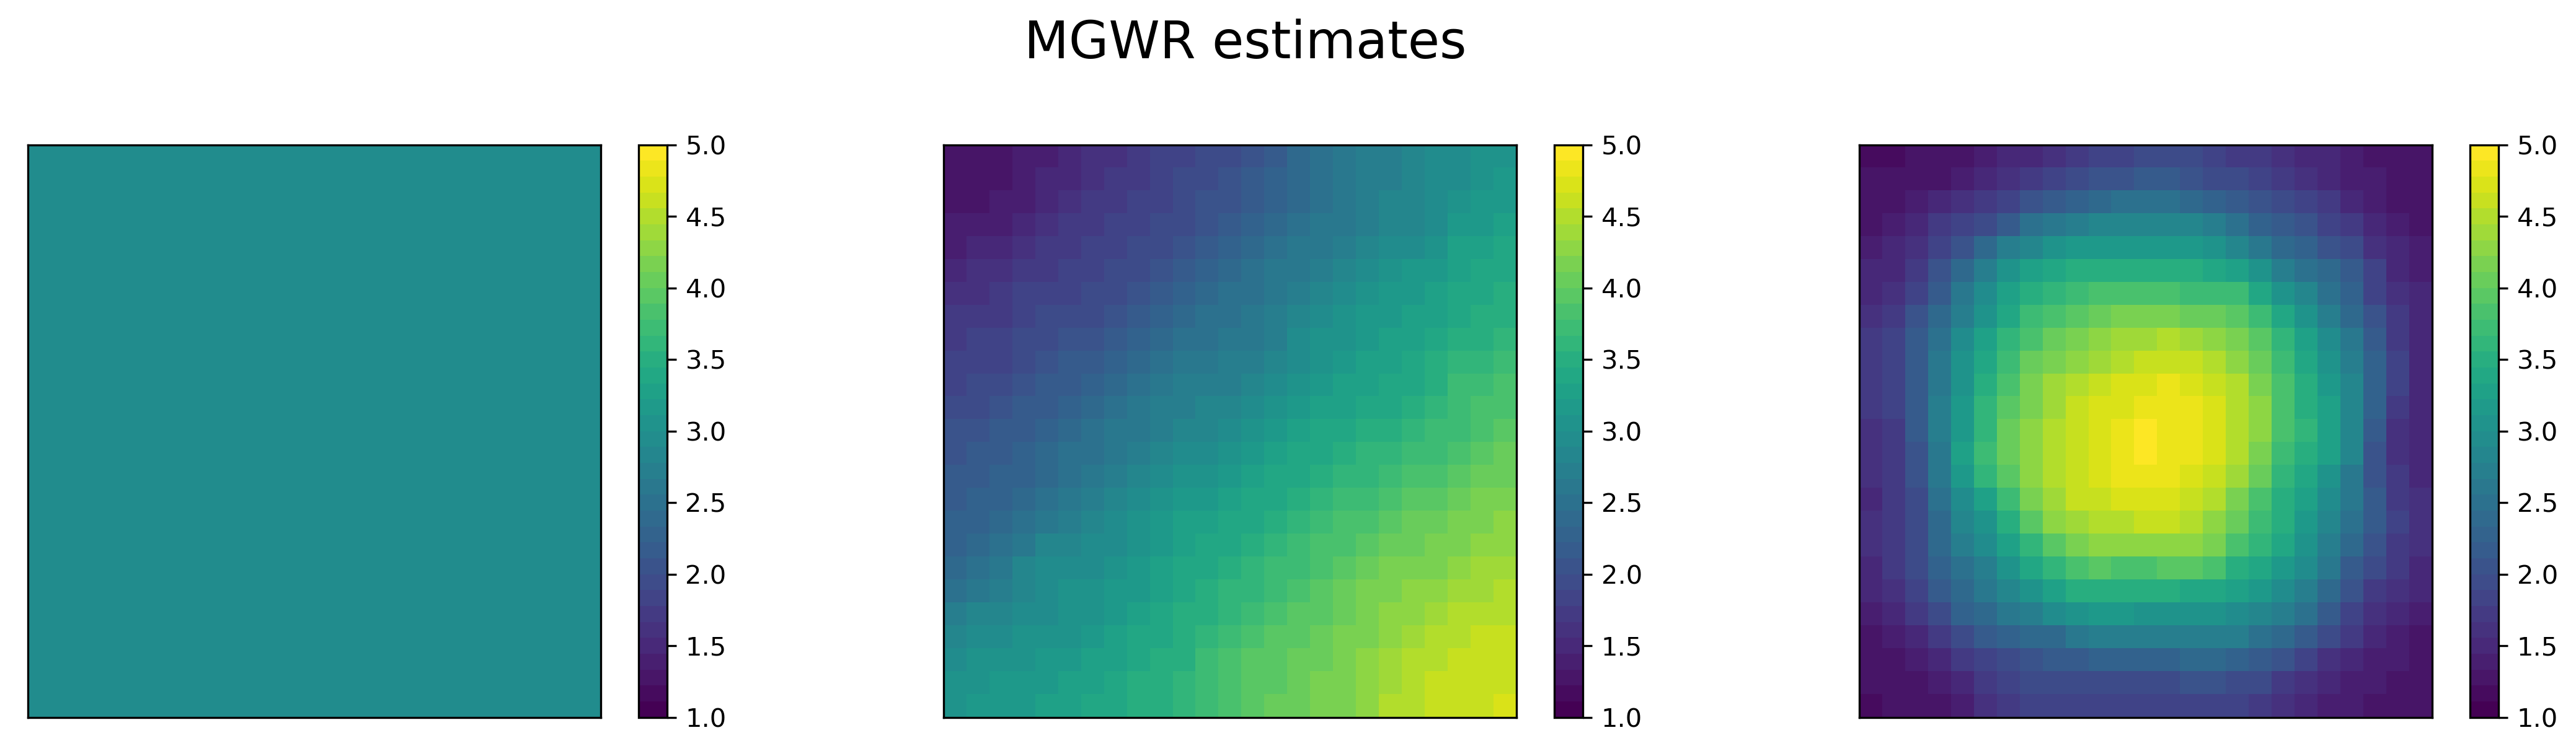

In [26]:
plot_s(mgwr_rslt.params.T,vmin=1,vmax=5,title="MGWR estimates")